In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import vanillaWH
import vanillaWH_tools

%matplotlib inline

# configuring plots
#plt.rc('text', usetex=True)             # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 14})  # increase font size

In [27]:
# initial conditions

# particle array as [x, y, z, vx, vy, vz, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])
p2 = np.array([2., 0., 0., 0., 0.7, 0., 1e-3])
sim = np.stack([p0, p1, p2])

sim = vanillaWH_tools.move_to_com(sim)

timestep = 0.01
N_steps = 10000

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim), 3, N_steps)) # [object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim[:,0], sim[:,1]

start = time.time()

simj = vanillaWH_tools.inertial_to_jacobi(sim)

for i in range(N_steps):
    
    # drift
    simj = vanillaWH.drift(simj, sim, object_num = 1, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 2, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)
    
    # kick
    simj = vanillaWH.kick(simj, sim, h=timestep)
    
    # drift
    simj = vanillaWH.drift(simj, sim, object_num = 1, h=timestep/2)
    simj = vanillaWH.drift(simj, sim, object_num = 2, h=timestep/2)
    sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)

    E = vanillaWH_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim[:,0]
    orbit_soln[:, 1, i] = sim[:,1]
    orbit_soln[:, 2, i] = sim[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 5.2 s


In [28]:
sim = rebound.Simulation()
sim.integrator='whfast'
sim.dt = timestep
sim.add(m=1.)
sim.add(m=1e-3, x=1., vy=1.)
sim.add(m=1e-3, x=2., vy=0.7)

sim.move_to_com()

energy_error_reb = np.zeros(N_steps) 
E0 = sim.calculate_energy()

orbit_soln_rebound = np.zeros((3, 3, N_steps))
diff0, diff1, diff2 = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)

for i in range(N_steps):
    sim.step() 
    
    E = sim.calculate_energy()
    energy_error_reb[i] = np.abs((E-E0)/E0)
    
    orbit_soln_rebound[0,:,i] = sim.particles[0].x, sim.particles[0].y, sim.particles[0].z
    orbit_soln_rebound[1,:,i] = sim.particles[1].x, sim.particles[1].y, sim.particles[1].z
    orbit_soln_rebound[2,:,i] = sim.particles[2].x, sim.particles[2].y, sim.particles[2].z
    
    dx0 = orbit_soln_rebound[0,0,i]-orbit_soln[0,0,i]
    dy0 = orbit_soln_rebound[0,1,i]-orbit_soln[0,1,i]
    dz0 = orbit_soln_rebound[0,2,i]-orbit_soln[0,2,i]
    diff0[i] = np.sqrt(dx0**2 + dy0**2 + dz0**2)
    
    dx1 = orbit_soln_rebound[1,0,i]-orbit_soln[1,0,i]
    dy1 = orbit_soln_rebound[1,1,i]-orbit_soln[1,1,i]
    dz1 = orbit_soln_rebound[1,2,i]-orbit_soln[1,2,i]
    diff1[i] = np.sqrt(dx1**2 + dy1**2 + dz1**2)
    
    dx2 = orbit_soln_rebound[2,0,i]-orbit_soln[2,0,i]
    dy2 = orbit_soln_rebound[2,1,i]-orbit_soln[2,1,i]
    dz2 = orbit_soln_rebound[2,2,i]-orbit_soln[2,2,i]
    diff2[i] = np.sqrt(dx2**2 + dy2**2 + dz2**2)


Integrate with timestep = 0.01 for 10000 steps = 15.913902759758617 years.


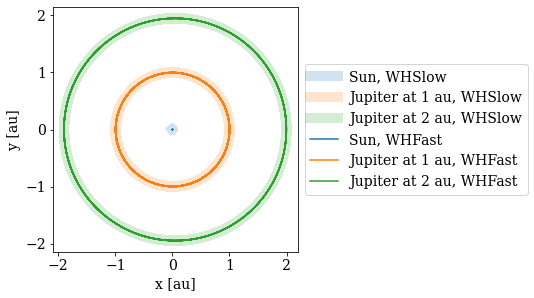

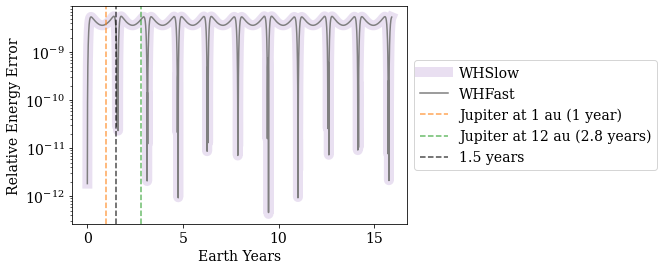

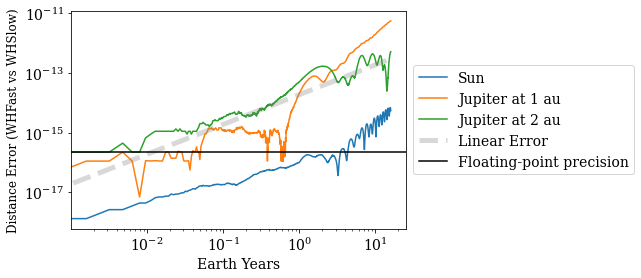

In [41]:
years = timestep * np.arange(N_steps) / (2*np.pi)
print('Integrate with timestep =', timestep, 'for', N_steps, 'steps =', years[-1], 'years.')

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], lw=10, alpha=0.2, label='Sun, WHSlow', c='tab:blue')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], lw=10, alpha=0.2, label='Jupiter at 1 au, WHSlow', c='tab:orange')
plt.plot(orbit_soln[2,0], orbit_soln[2,1], lw=10, alpha=0.2, label='Jupiter at 2 au, WHSlow', c='tab:green')
plt.plot(orbit_soln_rebound[0,0], orbit_soln_rebound[0,1], label='Sun, WHFast', c='tab:blue')
plt.plot(orbit_soln_rebound[1,0], orbit_soln_rebound[1,1], label='Jupiter at 1 au, WHFast', c='tab:orange')
plt.plot(orbit_soln_rebound[2,0], orbit_soln_rebound[2,1], label='Jupiter at 2 au, WHFast', c='tab:green')
plt.axis('scaled')
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(years, energy_error, lw=10, alpha=0.2, label='WHSlow', c='tab:purple')
plt.plot(years, energy_error_reb, label='WHFast', c='tab:gray')
plt.axvline(1, ls='--', alpha=0.7, label='Jupiter at 1 au (1 year)', c='tab:orange')
plt.axvline(2.8, ls='--', alpha=0.7, label='Jupiter at 12 au (2.8 years)', c='tab:green')
plt.axvline(1.5, ls='--', alpha=0.7, label='1.5 years', c='black')
plt.yscale('log')
plt.xlabel('Earth Years')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.plot(years, diff0, label='Sun', c='tab:blue')
plt.plot(years, diff1, label='Jupiter at 1 au', c='tab:orange')
plt.plot(years, diff2, label='Jupiter at 2 au', c='tab:green')
plt.plot(years, 3e-17*np.arange(N_steps),ls = '--', c='grey', lw=5, alpha=0.3, label='Linear Error')
plt.axhline(sys.float_info.epsilon, label='Floating-point precision', c='black')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Earth Years')
plt.ylabel('Distance Error (WHFast vs WHSlow)', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [30]:
# particle array as [rx, ry, vx, vy, m]
p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])
p2 = np.array([2., 0., 0., 0., 0.7, 0., 1e-3])
sim = np.stack([p0, p1, p2])

sim = vanillaWH_tools.move_to_com(sim)

print('sim before transform', sim[:,:5])

simj = vanillaWH_tools.inertial_to_jacobi(sim)

print('simj after transform', simj[:,:5])

sim = vanillaWH_tools.jacobi_to_inertial(simj, sim)

print('sim after transform back', sim[:,:5])

sim before transform [[-2.99401198e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.69660679e-03]
 [ 9.97005988e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.98303393e-01]
 [ 1.99700599e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.98303393e-01]]
simj after transform [[-4.32815239e-19  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -4.32815239e-19]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00]
 [ 1.99900100e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.99000999e-01]]
sim after transform back [[-2.99401198e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.69660679e-03]
 [ 9.97005988e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.98303393e-01]
 [ 1.99700599e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.98303393e-01]]
